In [15]:
%pylab inline
#%config InlineBackend.figure_format = 'retina' 

Populating the interactive namespace from numpy and matplotlib


In [16]:
#here are some common modules:
import scipy as sp #library of scientific functions
import scipy.io 
import scipy.signal as signal
import numpy as np #library of math functions
import pandas as pd #library of data analysis functions
import matplotlib.pyplot as plt #functions to plot data
import os #This lets python talk to your opperating system to open and save files.
from parabolic import parabolic
import matplotlib.mlab as mlab

In [17]:
filename = 'emodat.mat' #adjut file name here
filename = os.path.join('../FM-BCI', filename) #adjust filepath 
datafile = sp.io.loadmat(filename) #loading filename
#print datafile.keys()
voltageSamples = datafile['data'] 
#print voltageSamples.shape, len(voltageSamples)

In [18]:
variances = []
means = []
medians = []
standardDeviations = []
for i in range(len(voltageSamples)):
    variances.append(np.var(voltageSamples[i,:]))
    means.append(np.mean(voltageSamples[i,:]))
    medians.append(np.median(voltageSamples[i,:]))
    standardDeviations.append(np.std(voltageSamples[i,:]))

In [19]:
for i in range(len(voltageSamples)):
    print 'Channel', i+1
    print '\tmean:', means[i]
    print '\tmedian:', medians[i]
    print '\tstandard deviation:', standardDeviations[i]
    print '\tvariance:', np.var(voltageSamples)

Channel 1
	mean: 53.5051604742
	median: 8.42684103561
	standard deviation: 105.317167517
	variance: 11091.7057739


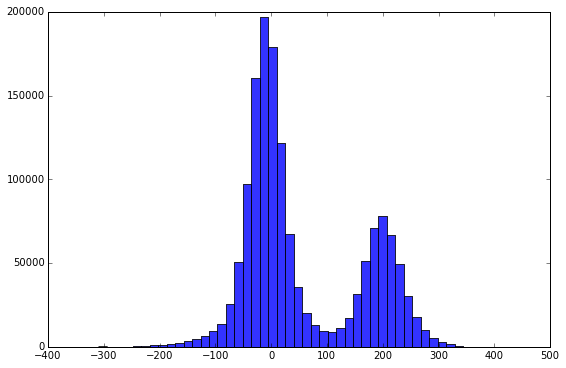

In [20]:
fig1 = plt.figure(1, figsize=(9,6))
numBins = 50
n, bins, patches = plt.hist(voltageSamples[0],numBins,alpha=0.8)


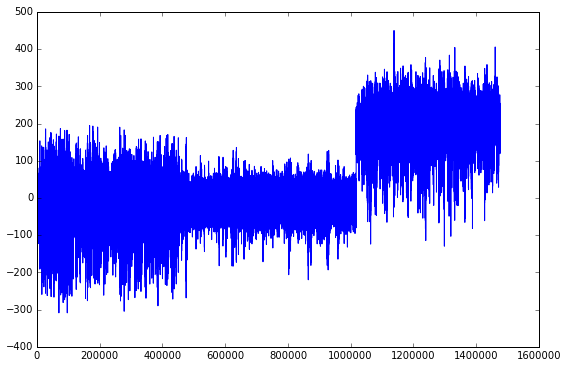

In [21]:
fig2 = plt.figure(2, figsize=(9,6))
plt.plot(voltageSamples[0])

Channel weights: 

         1     1.0
         2     0.875
         3     0.75
         4     0.625
         5     0.5
         6     0.375
         7     0.25
         8     0.125


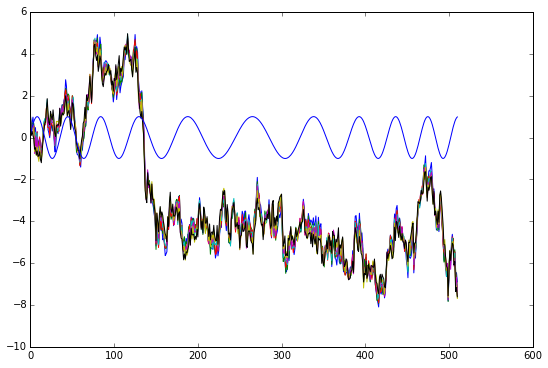

In [22]:
sampleRate = 512 # sample rate assumed during recording
sampleSpacing = 1.0 / sampleRate # time between samples in seconds
dataLengthSecs = 60 # length of whole recording
dataLengthSamples = dataLengthSecs*sampleRate # length of whole recording in samples

t = np.arange(0,dataLengthSecs,sampleSpacing) # time vector spanning length in seconds, with approp. num of samples
#numOfChannel = voltageSamples.shape[0] # determine number of channels from data, i.e. not predefined
numOfChannel = 8
voltageSamples = np.empty([numOfChannel, dataLengthSamples])

# channel weighting
channelWeights = np.linspace(1,1./numOfChannel,numOfChannel) 
#np.random.shuffle(channelWeights)
print 'Channel weights:', '\n'
for channelIndex in range(numOfChannel):
    print "        ", channelIndex+1, "   ", channelWeights[channelIndex]
    
# frequency modulation parameters
alphaCenter = 10.25   # Hz the carrier frequency
alphaModFreq = 1  # Hz the modulating frequency
alphaFreqDev = 4   # Hz of the frequency deviation

# signal to noise parameters
snr = 2             # signal / noise
noiseMean = 0
noiseStdDev = 0.5
alphaMean = 0
alphaStdDev = abs(np.sqrt(snr*(noiseStdDev**2))) # std of sine wave
alphaAmp = np.sqrt(2)*alphaStdDev
h = alphaFreqDev/alphaModFreq         # Modulation index

# Constructs 1/f noise by iteratively adding normal random noise, effectively the CDF of normal dist.
normalNoise = np.random.normal(noiseMean, noiseStdDev, (1,dataLengthSamples))
pinkNoise = np.cumsum(normalNoise)

# Frequency modulated alpha rhythm, a sinusoidal baseband signal
alpha = alphaAmp*np.sin( alphaCenter  * 2.0 * np.pi * t + alphaFreqDev*np.sin(2 * np.pi * alphaModFreq * t) / alphaModFreq)

# assign the weighted alpha rhythm + 1/f noise + additional random noise to each channel in sample
for channelIndex in range(0,numOfChannel):
    voltageSamples[channelIndex,:] = channelWeights[channelIndex]*alpha + pinkNoise + 0.5*np.random.random([1,dataLengthSamples])    
voltageSamples[channelIndex,:] = alpha # change last channel to ground truth alpha

fig3 = plt.figure(3, figsize=(9,6))

channelArray = np.vsplit(voltageSamples,1)
for channelIndex in range(0,numOfChannel):
    plt.plot(voltageSamples[channelIndex,1:sampleRate])
plt.show()


In [23]:
def butter_bandpass(lowcut, highcut, fs, order=4):
        #lowcut is the lower bound of the frequency that we want to isolate
        #hicut is the upper bound of the frequency that we want to isolate
        #fs is the sampling rate of our data
        nyq = 0.5 * fs #nyquist frequency - see http://www.dspguide.com/ if you want more info
        low = float(lowcut) / nyq
        high = float(highcut) / nyq
        b, a = sp.signal.butter(order, [low, high], btype='band')
        return b, a

def butter_bandpass_filter(mydata, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sp.signal.filtfilt(b, a, mydata)
    return y

winLengthSecs = 1 # predefine length of window.
winLengthSamples = winLengthSecs*sampleRate # length of window in samples
numOfWindows = int(dataLengthSamples/winLengthSamples) # determine number of windows
channelPeaks = np.empty([numOfChannel, numOfWindows]) # container for peak frequencies for each channel every second
desiredFreqResolution = 0.01 # predefine resolution of spectrum
fftLengthSamples = int(sampleRate/desiredFreqResolution)
nyq = 0.5*sampleRate # maximum possible frequency to measure
freqs = scipy.fftpack.rfftfreq(fftLengthSamples,sampleSpacing) # retrieve frequency axis

bandLow = 9.5                                # lower alpha band 
bandHigh = 10.5                              # higher alpha band
orderFilter = 4  

arrayOfAmps = np.empty([numOfChannel, numOfWindows, len(freqs)])

for channelIndex in range(0,numOfChannel):
    for winIndex in range(0,numOfWindows):
        channelVoltage = voltageSamples[channelIndex,:]
        channelVoltageFilt = butter_bandpass_filter(channelVoltage, bandLow, bandHigh,sampleRate,orderFilter)
            
        # get next window of data, detrend
        winStart = int(winIndex*winLengthSecs*sampleRate)
        winEnd = int((winIndex+1)*winLengthSecs*sampleRate)
        channelVoltageWin = channelVoltageFilt[winStart:winEnd] - np.mean(channelVoltageFilt[winStart:winEnd])
        
        # window next window of data
        winLengthSamples = len(channelVoltageWin) # determine window length
        #windowed = channelVoltage * signal.blackmanharris(winLengthSamples)
        windowedWin = channelVoltageWin * signal.gaussian(winLengthSamples, std=8,sym=False)
       
        # compute fft
        #TODO Populate new 3D array of shape numOfChannelxnumOfWindowsxlen(winAmp) with amp values
        winAmp = abs(scipy.fftpack.rfft(channelVoltageWin,fftLengthSamples)) # determine amplitude spectrum by taking abs
        arrayOfAmps[channelIndex, winIndex] = winAmp

        # find peak frequency
        maxAmplitudeIndex = np.argmax(winAmp) # finds simple max amp peak
        true_maxAmplitudeIndex = parabolic(np.log(winAmp), maxAmplitudeIndex-1)[0] # finds parabolic interpolation
        maxFreq = freqs[int(maxAmplitudeIndex)] # retrieves frequency of peak
        true_maxFreq = nyq * true_maxAmplitudeIndex / fftLengthSamples # retrieves frequency of parabolic peak
        print('Channel '+str(channelIndex+1)+ ', Window '+str(winIndex+1)+':     '+str(true_maxFreq)+'  '+str(maxFreq))
        channelPeaks[channelIndex,winIndex] = true_maxFreq # stores peak frequency for every window

Channel 1, Window 1:     9.92999971973  9.94
Channel 1, Window 2:     10.0699997456  10.08
Channel 1, Window 3:     9.94499976278  9.95
Channel 1, Window 4:     9.77999987012  9.79
Channel 1, Window 5:     10.1249998357  10.13
Channel 1, Window 6:     9.40999988504  9.42
Channel 1, Window 7:     9.77999943184  9.79
Channel 1, Window 8:     10.4349998574  10.44
Channel 1, Window 9:     9.94499941405  9.95
Channel 1, Window 10:     10.0849997772  10.09
Channel 1, Window 11:     10.2849993979  10.29
Channel 1, Window 12:     10.0149996372  10.02
Channel 1, Window 13:     10.224999714  10.23
Channel 1, Window 14:     10.26999943  10.28
Channel 1, Window 15:     9.87499955643  9.88
Channel 1, Window 16:     9.91499964299  9.92
Channel 1, Window 17:     10.1749999673  10.18
Channel 1, Window 18:     10.1399996045  10.15
Channel 1, Window 19:     10.1349994436  10.14
Channel 1, Window 20:     9.89999977111  9.91
Channel 1, Window 21:     9.94999971124  9.96
Channel 1, Window 22:     10.139999

In [24]:
print np.median(channelPeaks,1)
print np.mean(channelPeaks,1)

[ 10.13999966  10.11999976  10.10499988  10.0599999   10.00999968
  10.00499984   9.98749964  10.24499964]
[ 10.13316636  10.09816636  10.08833304  10.03058301  10.00341633
   9.99124965   9.99566632  10.2381665 ]


In [25]:
chPeakVariances = []
chPeakMeans = []
chPeakMedians = []
chPeakStandardDeviations = []
for i in range(len(channelPeaks)):
    chPeakVariances.append(np.var(channelPeaks[i,:]))
    chPeakMeans.append(np.mean(channelPeaks[i,:]))
    chPeakMedians.append(np.median(channelPeaks[i,:]))
    chPeakStandardDeviations.append(np.std(channelPeaks[i,:]))

In [26]:
for i in range(len(channelPeaks)):
    print 'Channel ' + str(i+1) + ' Peaks'
    print '\tmean:', chPeakMeans[i]
    print '\tmedian:', chPeakMedians[i]
    print '\tstandard deviation:', chPeakStandardDeviations[i]
    print '\tvariance:', chPeakVariances[i]

Channel 1 Peaks
	mean: 10.1331663592
	median: 10.139999664
	standard deviation: 0.195192118259
	variance: 0.0380999630304
Channel 2 Peaks
	mean: 10.0981663584
	median: 10.1199997632
	standard deviation: 0.217326476964
	variance: 0.0472307975895
Channel 3 Peaks
	mean: 10.0883330399
	median: 10.1049998768
	standard deviation: 0.246009249262
	variance: 0.0605205507224
Channel 4 Peaks
	mean: 10.0305830128
	median: 10.0599999041
	standard deviation: 0.262394517106
	variance: 0.0688508826071
Channel 5 Peaks
	mean: 10.0034163284
	median: 10.009999678
	standard deviation: 0.282893489974
	variance: 0.0800287266696
Channel 6 Peaks
	mean: 9.99124965366
	median: 10.0049998353
	standard deviation: 0.306082223101
	variance: 0.0936863272985
Channel 7 Peaks
	mean: 9.99566631762
	median: 9.98749964053
	standard deviation: 0.324927523021
	variance: 0.105577895217
Channel 8 Peaks
	mean: 10.2381664967
	median: 10.2449996421
	standard deviation: 0.0350828258109
	variance: 0.00123080466688


/Users/alicia/anaconda/lib/python2.7/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


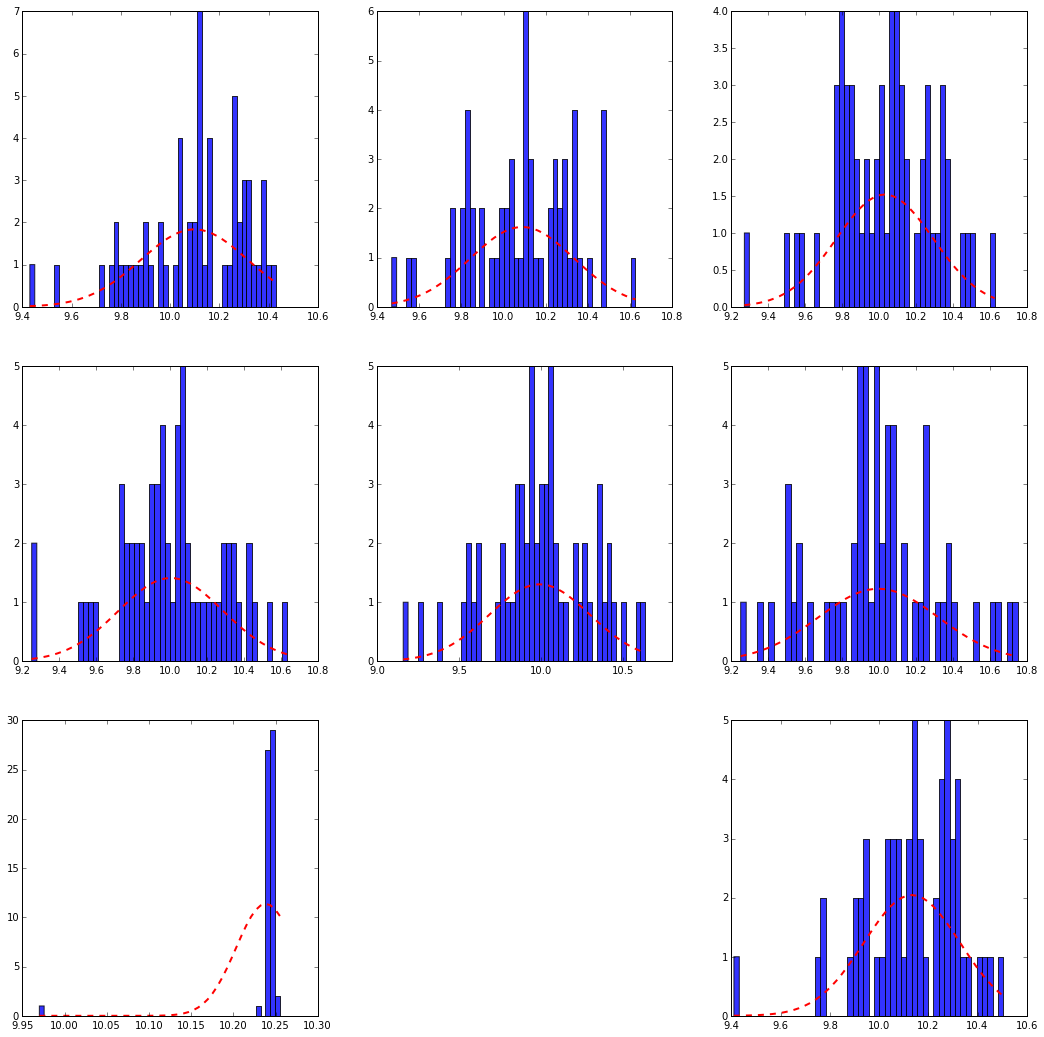

In [28]:
# Do this for all channels, one figure using subplot, each channel with its own subplot
fig4 = plt.figure(4, figsize=(18,18))
numBins = 50

for channelIndex in range(0, numOfChannel):
    plt.subplot(ceil(sqrt(numOfChannel)),ceil(sqrt(numOfChannel)),channelIndex)
    n, bins, patches = plt.hist(channelPeaks[channelIndex],numBins,alpha=0.8)
    y = mlab.normpdf( bins, chPeakMeans[channelIndex],chPeakStandardDeviations[channelIndex] )
    l = plt.plot(bins, y, 'r--', linewidth=2)

#for channelIndex in range(0, numOfChannel):
    
#n, bins, patches = plt.hist(channelPeaks[7],numBins,alpha=0.8)

In [29]:
# plot amp for each channel
#for each channel
    #for each window
        #plot 3d figure with time on horizontal, freqs on vertical, and winAmp as the fluctuating value
fig5 = plt.figure(5, figsize=(18,18))\n",

for channelIndex in range(0, numOfChannel):
    for winIndex in range(0, numOfWindows)

SyntaxError: unexpected character after line continuation character (<ipython-input-29-b66ce2e94483>, line 5)